# Introduction

**2nd mini-project report**

Natural Language

Authors: Piotr Migdałek, Jascha Jestel

Task: Hotel reviews - Sentiment analysis

# Load Data

In [ ]:
%pip install GitPython
%pip install wordcloud
%pip install seaborn
%pip install nltk
%pip install transformers
%pip install lightgbm
%pip install datasets

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import git
import os
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Dense, LSTM, Dropout, Bidirectional
from keras.preprocessing.text import Tokenizer

from lightgbm import LGBMClassifier

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from transformers import AutoTokenizer, TFAutoModel, TFDistilBertForSequenceClassification, TFDistilBertModel
from datasets import Dataset

In [ ]:
from numpy.random import seed
seed(42)

DATA_SOURCE = 'DRIVE'

if DATA_SOURCE == 'GIT':
  repo = git.Repo('.', search_parent_directories=True)
  data = train = pd.read_csv(os.path.join(repo.working_tree_dir, "MP2\\train.txt"), sep='\t', header = 0, names = ['sentiment','review'])

elif DATA_SOURCE == 'DRIVE':
  from google.colab import drive
  drive.mount('/content/drive')

  data = pd.read_csv("/content/drive/MyDrive/train.txt", sep='\t', header = 0, names = ['sentiment','review'])


In [ ]:
data.head(10)

,sentiment,review
0,TRUTHFULPOSITIVE,We stayed at the Omni between Christmas and Ne...
1,DECEPTIVENEGATIVE,I was REALLY looking forward to a nice relaxin...
2,TRUTHFULNEGATIVE,"First let me say, I try not to be too critical..."
3,DECEPTIVENEGATIVE,The Ambassador East Hotel is a terrible place ...
4,DECEPTIVENEGATIVE,I needed a place to stay for a business confer...
5,TRUTHFULNEGATIVE,Let me first start by saying I have always bee...
6,DECEPTIVEPOSITIVE,My wife and me stayed in the Amalfi Hotel Chic...
7,DECEPTIVENEGATIVE,My husband and I stayed here at the Hard Rock ...
8,TRUTHFULPOSITIVE,My wife and I just spent 3 nights at The Talbo...
9,DECEPTIVENEGATIVE,After staying at the Omni Chicago Hotel recent...


# No preprocessing LSTM baseline

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    data["review"].values,
    data["sentiment"].values,
    test_size=0.2,
    random_state=42,
    stratify=data["sentiment"].values
)

lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit(y_test)

print(x_train.shape)
print(x_test.shape)


(1119,)
(280,)


In [ ]:
#Tokenizing text
max_vocab = 50000
tokenizer = Tokenizer(num_words = max_vocab)
tokenizer.fit_on_texts(x_train)

#Turning text into sequence
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

#Padding sequences
x_train_seq_pad = pad_sequences(x_train_seq)
x_test_seq_pad = pad_sequences(x_test_seq, maxlen = np.array(x_train_seq_pad).shape[1])

## Embedding (100-dim.) + LSTM


In [ ]:
model = keras.Sequential(
    [
        Embedding(max_vocab + 1, 100, input_length = np.array(x_train_seq_pad).shape[1], mask_zero=True),
        LSTM(128, dropout = 0.3, recurrent_dropout = 0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(4, activation='softmax')
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 784, 100)          5000100   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 4)                 516       
                                                                 
Total params: 5134376 (19.59 MB)
Trainable params: 5134376 (19.59 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(x_train_seq_pad, y_train, batch_size = 64, epochs = 8, validation_split=0.1)

Epoch 1/8
16/16 [==============================] - 105s 6s/step - loss: 1.3848 - accuracy: 0.2781 - val_loss: 1.3804 - val_accuracy: 0.3304
Epoch 2/8
16/16 [==============================] - 87s 5s/step - loss: 1.3546 - accuracy: 0.4499 - val_loss: 1.2732 - val_accuracy: 0.5268
Epoch 3/8
16/16 [==============================] - 95s 6s/step - loss: 1.1197 - accuracy: 0.5462 - val_loss: 0.9377 - val_accuracy: 0.5268
Epoch 4/8
16/16 [==============================] - 86s 5s/step - loss: 0.7777 - accuracy: 0.6882 - val_loss: 0.8354 - val_accuracy: 0.7143
Epoch 5/8
16/16 [==============================] - 90s 6s/step - loss: 0.5346 - accuracy: 0.7944 - val_loss: 0.8295 - val_accuracy: 0.6161
Epoch 6/8
16/16 [==============================] - 118s 7s/step - loss: 0.4688 - accuracy: 0.8292 - val_loss: 0.6795 - val_accuracy: 0.7232
Epoch 7/8
16/16 [==============================] - 90s 6s/step - loss: 0.2988 - accuracy: 0.8967 - val_loss: 0.8238 - val_accuracy: 0.6696
Epoch 8/8
16/16 [========

In [ ]:
score = model.evaluate(x_test_seq_pad, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.9828721284866333
Test accuracy: 0.5964285731315613


## Embedding (64-dim.) + LSTM

In [ ]:
model2 = keras.Sequential(
    [
        Embedding(max_vocab + 1, 64, input_length = np.array(x_train_seq_pad).shape[1]),
        LSTM(128, dropout = 0.3, recurrent_dropout = 0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(4, activation='softmax')
    ]
)
model2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model2.fit(x_train_seq_pad, y_train, batch_size = 32, epochs = 8, validation_split=0.1)
score = model2.evaluate(x_test_seq_pad, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Epoch 1/8
32/32 [==============================] - 138s 4s/step - loss: 1.3853 - accuracy: 0.2522 - val_loss: 1.3772 - val_accuracy: 0.3393
Epoch 2/8
32/32 [==============================] - 128s 4s/step - loss: 1.2501 - accuracy: 0.4350 - val_loss: 1.1729 - val_accuracy: 0.4911
Epoch 3/8
32/32 [==============================] - 121s 4s/step - loss: 0.9323 - accuracy: 0.5402 - val_loss: 0.9382 - val_accuracy: 0.4643
Epoch 4/8
32/32 [==============================] - 95s 3s/step - loss: 0.7038 - accuracy: 0.6495 - val_loss: 0.8697 - val_accuracy: 0.6161
Epoch 5/8
32/32 [==============================] - 59s 2s/step - loss: 0.7021 - accuracy: 0.7309 - val_loss: 0.8891 - val_accuracy: 0.5714
Epoch 6/8
32/32 [==============================] - 64s 2s/step - loss: 0.4849 - accuracy: 0.8213 - val_loss: 0.7403 - val_accuracy: 0.7232
Epoch 7/8
32/32 [==============================] - 65s 2s/step - loss: 0.2959 - accuracy: 0.8858 - val_loss: 0.8887 - val_accuracy: 0.7232
Epoch 8/8
32/32 [=======

## Embedding (128-dim.) + Bidirectional LSTM

In [ ]:
model3 = keras.Sequential(
    [
        Embedding(max_vocab + 1, 128, input_length = np.array(x_train_seq_pad).shape[1]),
        Bidirectional(LSTM(64, return_sequences=True)),
        Bidirectional(LSTM(64)),
        Dense(4, activation='softmax')
    ]
)
model3.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model3.fit(x_train_seq_pad, y_train, batch_size = 32, epochs = 5, validation_split=0.1)
score = model3.evaluate(x_test_seq_pad, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Epoch 1/5
32/32 [==============================] - 96s 3s/step - loss: 1.3776 - accuracy: 0.2810 - val_loss: 1.3263 - val_accuracy: 0.4375
Epoch 2/5
32/32 [==============================] - 103s 3s/step - loss: 0.9359 - accuracy: 0.6425 - val_loss: 0.8595 - val_accuracy: 0.6875
Epoch 3/5
32/32 [==============================] - 91s 3s/step - loss: 0.4836 - accuracy: 0.8371 - val_loss: 0.9660 - val_accuracy: 0.6250
Epoch 4/5
32/32 [==============================] - 126s 4s/step - loss: 0.2634 - accuracy: 0.9186 - val_loss: 0.8376 - val_accuracy: 0.7411
Epoch 5/5
32/32 [==============================] - 101s 3s/step - loss: 0.1198 - accuracy: 0.9712 - val_loss: 1.0435 - val_accuracy: 0.6875
Test loss: 1.0958651304244995
Test accuracy: 0.6464285850524902


Due to the corpus having not sufficent (~1400) number of reviews, neural embedding was probably fitted poorly and then LSTM network performed fairly mediocore (~70%) due to overfitting tendency.

# EDA

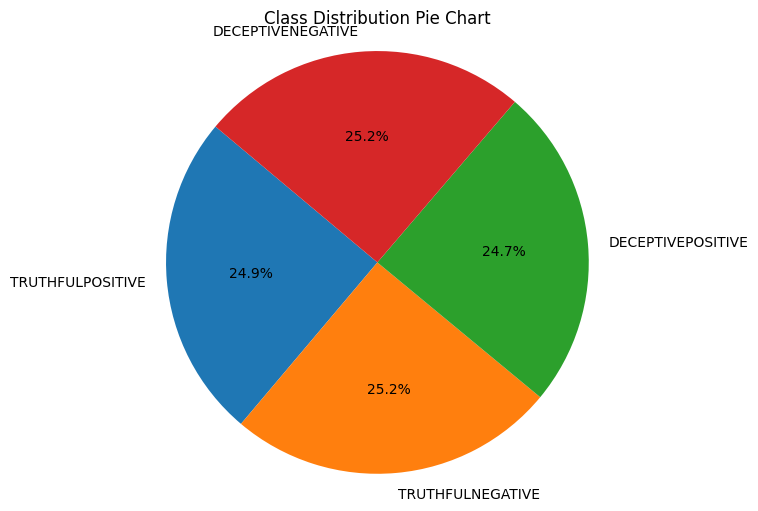

In [ ]:
plt.figure(figsize=(6, 6))
labels = ['TRUTHFULPOSITIVE', 'TRUTHFULNEGATIVE', 'DECEPTIVEPOSITIVE', 'DECEPTIVENEGATIVE']
values = [len(data[data['sentiment'] == label]) for label in labels]
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution Pie Chart')
plt.axis('equal')
plt.show()

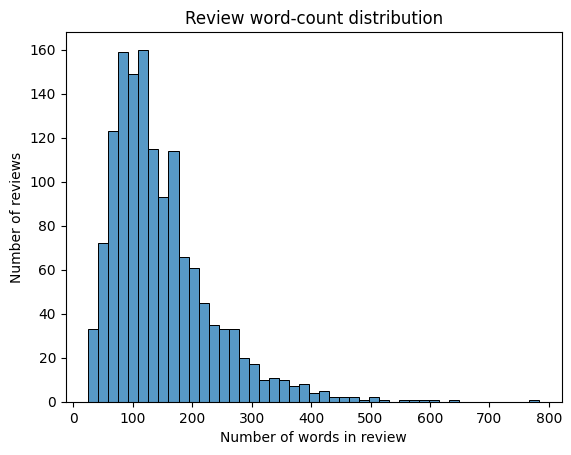

In [ ]:
g = sns.histplot(data['review'].apply(lambda x: len(x.split())))
g.set(xlabel='Number of words in review',
      ylabel='Number of reviews',
      title='Review word-count distribution')
plt.show()

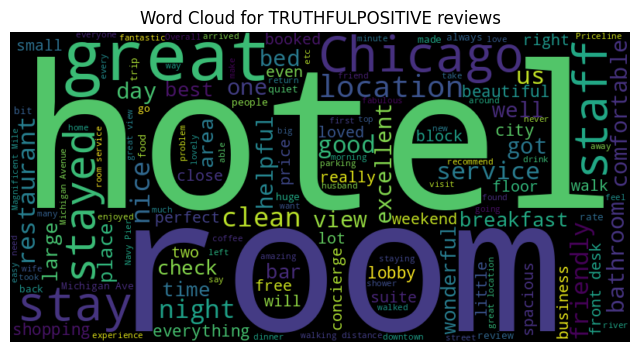

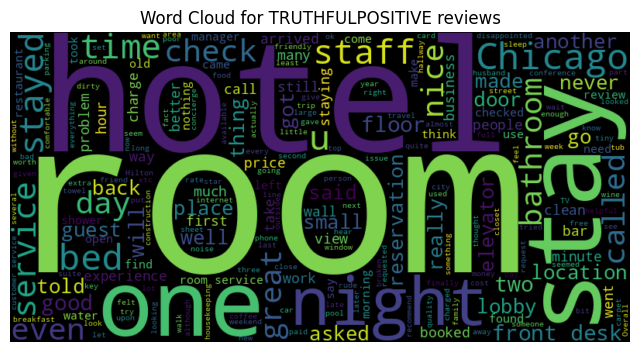

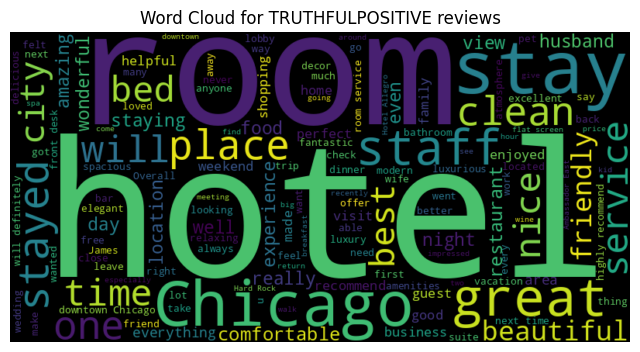

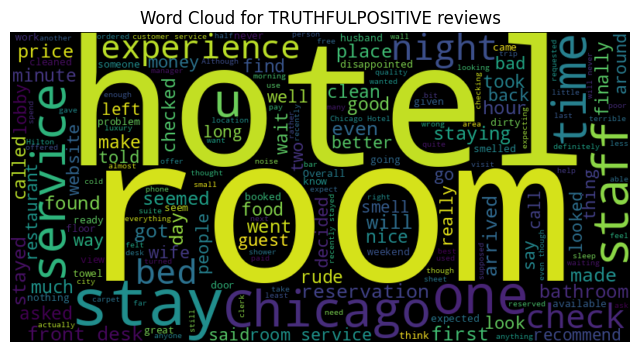

In [ ]:
def print_word_cloud(label):
    wcTP = WordCloud(max_words=1000,
                     min_font_size=10,
                     height=400,
                     width=800,
                     background_color="black").generate(" ".join(data[data["sentiment"]==label].review))
    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(wcTP, interpolation='bilinear')
    ax.set_axis_off()
    ax.set_title('Word Cloud for TRUTHFULPOSITIVE reviews')
    plt.show()

print_word_cloud("TRUTHFULPOSITIVE")
print_word_cloud("TRUTHFULNEGATIVE")
print_word_cloud("DECEPTIVEPOSITIVE")
print_word_cloud("DECEPTIVENEGATIVE")

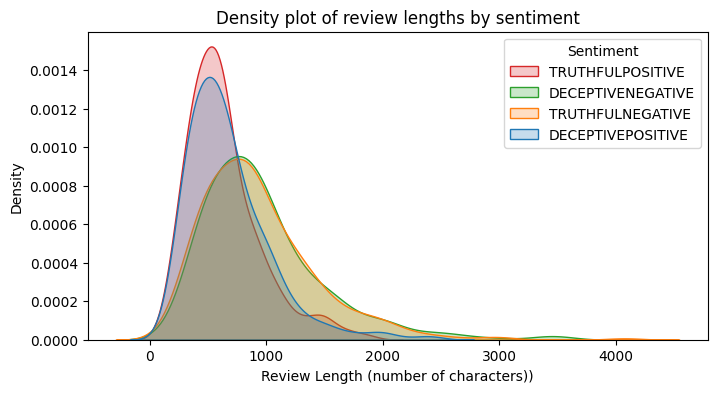

In [ ]:
data['length'] = data['review'].apply(lambda x: len(x))

plt.figure(figsize=(8, 4))
sns.kdeplot(data=data, x='length', hue='sentiment', common_norm=False, fill=True)
plt.xlabel('Review Length (number of characters))')
plt.ylabel('Density')
plt.title('Density plot of review lengths by sentiment')
plt.legend(title='Sentiment', labels=data['sentiment'].unique())
plt.show()

In [ ]:
# TODO think of other visualisations?

def count_all_caps(text):
    return len(re.findall(r'\b[A-Z]{2,}\b', text))

all_caps_count = data['review'].apply(count_all_caps)

#data['positive'] = (data['sentiment'] == 'TRUTHFULPOSITIVE') | (data['sentiment'] == 'DECEPTIVEPOSITIVE')
#data['truthful'] = (data['sentiment'] == 'DECEPTIVENEGATIVE') | (data['sentiment'] == 'DECEPTIVEPOSITIVE')

#plt.figure(figsize=(8, 4))
#sns.histplot(data=data[data['all_caps_count'] > 1] , x='all_caps_count', hue='truthful', common_norm=False, multiple='stack', stat='density')

# Preprocessing

## Lemmatization + Stop Word Removal

In [ ]:
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('omw-1.4')
# nltk.download('wordnet')

In [ ]:
data['review'][0]

"We stayed at the Omni between Christmas and New Year's in 2008 just to get away for a few days. We found it through web deals and got a penthouse suite very cheap. So this year we checked online just a day or so after Christmas and the deal was there again. It also included parking at the great price. Huge suite overlooking downtown Chicago. Best location to walk EVERYWHERE. My 12 and 11 yr olds loved swimming at night and the chocolate cookies on their pillows. Can't wait to go back. "

In [121]:
# Lemmatize with POS Tag (Parts of Speech tagging)
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)


def clean(review):
    review = re.sub("[^a-z A-Z 0-9-]+", "", review)

    # tokenize the sentences
    review = word_tokenize(review)

    # transform to lower case if not all caps
    review = [w.lower() if not w.isupper() else w for w in review]

    # filter stopwords
    review = [t for t in review if t not in stopwords.words("english")]

    # lemmatize each token
    review = [lemmatizer.lemmatize(t, get_wordnet_pos(t)) for t in review]

    return review


lemmatizer = WordNetLemmatizer()
data["review_clean"] = data["review"].apply(clean)

## Soft cleaning

In [6]:
# only convert to lover case and remove double spaces for DistilBERT model
def soft_clean_text(text):
    text = text.lower()
    # text = re.sub("[^a-z A-Z]+", "", text)
    text = re.sub(r'\s+', ' ', text)
    return text


data['review_soft_clean'] = data["review"].apply(soft_clean_text)

# Model Training

## TF-IDF

In [122]:
# train (80%) and test split (20%)
# save index for train and test set to use for all models
train_index, test_index, _, _ = train_test_split(
    range(len(data)),
    data["sentiment"].values,
    test_size=0.2,
    random_state=42,
    stratify=data["sentiment"].values
)

x_train = data["review_clean"].values[train_index]
x_test = data["review_clean"].values[test_index]
y_train = data["sentiment"].values[train_index]
y_test = data["sentiment"].values[test_index]

def id_tokenizer(text):
    return text


# vectorizing training corpus with tfidf
tfidf = TfidfVectorizer(
    analyzer = 'word',
    tokenizer = id_tokenizer,
    preprocessor = id_tokenizer,
    token_pattern = None)

x_train_tf = tfidf.fit_transform(x_train)
x_test_tf = tfidf.transform(x_test)


In [ ]:
#now for 1119 reviews in the training set, we have 1119 vectors of length 7288
print(x_train_tf.shape)

(1119, 7288)


In [ ]:
## analyze vocabulary
vocab_clean = tfidf.get_feature_names_out()
print('The vocabulary contains ' + str(len(vocab_clean)) + ' tokens.')
print('Some examples of these tokens:')
print(vocab_clean[0:50])
# TODO analyse somehow else?

The vocabulary contains 7288 tokens.
Some examples of these tokens:
['-' '--' '-2' '-20' '-5' '-6' '-barely' '-broken' '-clean' '-eno'
 '-entire' '-every' '-front' '-good' '-housekeeping' '-lack' '-nice'
 '-our' '-rooms' '-shower' '-small' '-some' '-the' '-they' '-up' '-you'
 '0' '060405' '1' '1-2smo' '1-3' '1-star' '10' '10-120' '10-15'
 '10-minutes' '10-year-old' '100' '1000' '10000' '1010' '1030' '1030pm'
 '10363' '104' '1045' '105' '1050glass' '105mph' '107']


The vocabulary includes some odd looking words with "-" and some all caps words. Without the vocabulary is about 300 tokens less but the performance decreases slightly, therefore just keep all.

In [ ]:
best_model_results = []

### Logistic regression

In [ ]:
param_grid_lr = {
    'penalty': ['l2', 'l1'],
    'C': [1, 5, 8, 10, 12],
    'solver': ['saga', 'liblinear'],
    'max_iter': [2000],
}

lr = LogisticRegression()

grid_search_lr = GridSearchCV(lr, param_grid_lr, cv=5, n_jobs=-1)
grid_search_lr.fit(x_train_tf, y_train)
lr = grid_search_lr.best_estimator_

print("Best hyperparameters: ", grid_search_lr.best_params_)
print("Best score: ", grid_search_lr.best_score_)
print("Test Accuracy  : {:.2f} %".format(accuracy_score(lr.predict(x_test_tf), y_test)*100))

best_model_results.append({'name': 'Logistic Regression',
                           'best_gs_score': grid_search_lr.best_score_,
                           'test_accuracy': accuracy_score(lr.predict(x_test_tf), y_test)})

Best hyperparameters:  {'C': 10, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'liblinear'}
Best score:  0.8204356181934658
Test Accuracy  : 83.93 %


### SVM

In [ ]:
param_grid_svc = {
        'C': [0.1, 0.5, 1, 2, 5, 10],
        'kernel': ['linear', 'rbf', 'poly'],
        'degree': [2, 3, 4],
        'gamma': ['scale', 'auto']
}

svc = SVC()
grid_search_svc = GridSearchCV(svc, param_grid_svc, cv=5, n_jobs=-1)
grid_search_svc.fit(x_train_tf, y_train)

svc = SVC(**grid_search_svc.best_params_)
svc.fit(x_train_tf, y_train)

print("Best hyperparameters: ", grid_search_svc.best_params_)
print("Best score: ", grid_search_svc.best_score_)
print("Test Accuracy  : {:.2f} %".format(accuracy_score(svc.predict(x_test_tf), y_test)*100))

best_model_results.append({'name': 'SVM',
                           'best_gs_score': grid_search_svc.best_score_,
                           'test_accuracy': accuracy_score(svc.predict(x_test_tf), y_test)})

Best hyperparameters:  {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Best score:  0.8213284753363229
Test Accuracy  : 83.21 %


### Random Forest

In [ ]:
param_grid_rf = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)

grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, n_jobs=-1)
grid_search_rf.fit(x_train_tf, y_train)
rf = grid_search_rf.best_estimator_

print("Best hyperparameters: ", grid_search_rf.best_params_)
print("Best score: ", grid_search_rf.best_score_)
print("Test Accuracy  : {:.2f} %".format(accuracy_score(rf.predict(x_test_tf), y_test)*100))

best_model_results.append({'name': 'Random Forest',
                           'best_gs_score': grid_search_rf.best_score_,
                           'test_accuracy': accuracy_score(rf.predict(x_test_tf), y_test)})

Best hyperparameters:  {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
Best score:  0.7801889814221653
Test Accuracy  : 73.57 %


### Naive Bayes

In [ ]:
nb = MultinomialNB()
param_grid_nb = {
    'alpha': [0.1, 0.5, 1, 2, 5, 10],
    'fit_prior': [True, False]
}

grid_search_nb = GridSearchCV(nb, param_grid_nb, cv=5, n_jobs=-1)
grid_search_nb.fit(x_train_tf, y_train)

nb = MultinomialNB(**grid_search_nb.best_params_)
nb.fit(x_train_tf, y_train)

print("Best hyperparameters: ", grid_search_nb.best_params_)
print("Best score: ", grid_search_nb.best_score_)
print("Test Accuracy  : {:.2f} %".format(accuracy_score(nb.predict(x_test_tf), y_test)*100))

best_model_results.append({'name': 'Naive Bayes',
                           'best_gs_score': grid_search_nb.best_score_,
                           'test_accuracy': accuracy_score(nb.predict(x_test_tf), y_test)})

Best hyperparameters:  {'alpha': 0.1, 'fit_prior': True}
Best score:  0.8097053171044202
Test Accuracy  : 81.43 %


### LightGBM

In [ ]:
param_grid_lgbm = {
        'num_leaves': [32, 64, 128],
        'max_depth': [3, 4, 5],
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.05],
        'min_child_samples': [10, 20],
        'colsample_bytree': [0.5, 0.7],
        'reg_alpha': [0, 0.1],
        'reg_lambda': [0, 0.1]
}

lgbm = LGBMClassifier(random_state=42)

grid_search_lgbm = GridSearchCV(lgbm, param_grid_lgbm, cv=5, n_jobs=-1)
grid_search_lgbm.fit(x_train_tf, y_train)
lgbm = grid_search_lgbm.best_estimator_

print("Best hyperparameters: ", grid_search_lgbm.best_params_)
print("Best score: ", grid_search_lgbm.best_score_)
print("Test Accuracy  : {:.2f} %".format(accuracy_score(lgbm.predict(x_test_tf), y_test)*100))

best_model_results.append({'name': 'LightGBM',
                           'best_gs_score': grid_search_lgbm.best_score_,
                           'test_accuracy': accuracy_score(lgbm.predict(x_test_tf), y_test)})

In [ ]:
print("Best hyperparameters:  {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_samples': 10, 'n_estimators': 100, 'num_leaves': 32, 'reg_alpha': 0.1, 'reg_lambda': 0.1}")
print("Best score:  0.7337604099935937")
print("Test Accuracy  : 72.50 %")

Best hyperparameters:  {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_samples': 10, 'n_estimators': 100, 'num_leaves': 32, 'reg_alpha': 0.1, 'reg_lambda': 0.1}
Best score:  0.7337604099935937
Test Accuracy  : 72.50 %


### Stacking Ensemble

In [124]:
# create the base estimators
estimators = [('nb', nb), ('svc', svc), ('lr', lr)]

# create the stacking classifier
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

stacking_clf.fit(x_train_tf, y_train)
print("Test Accuracy  : {:.2f} %".format(accuracy_score(stacking_clf.predict(x_test_tf), y_test)*100))

Test Accuracy  : 84.64 %


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Results

In [ ]:
pd.DataFrame(best_model_results).sort_values(by='test_accuracy', ascending=False)

,name,best_gs_score,test_accuracy
5,Stacking Ensemble,NaN,0.846429
0,Logistic Regression,0.820436,0.839286
1,SVM,0.821328,0.832143
2,Naive Bayes,0.809705,0.814286
3,Random Forest,0.780189,0.735714
4,LightGBM,0.733760,0.725000


Confusion Matrix for Stacking Ensemble (best model in terms of accuracy).

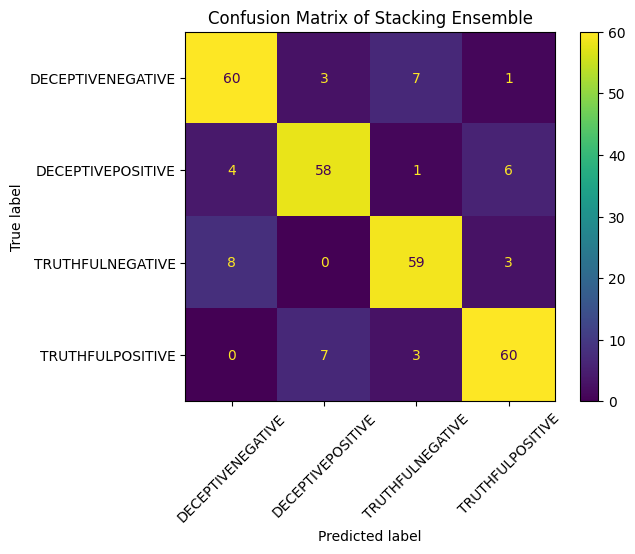

In [133]:
# plot confusion matrix of best performing model in terms of accuracy
pred_labels = stacking_clf.predict(x_test_tf)

cm = confusion_matrix(y_test, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=le.inverse_transform([0,1,2,3]))

disp.plot()
plt.xticks(rotation=45)
plt.title("Confusion Matrix of Stacking Ensemble")
plt.show()

For comparison, confusion matrix of best accuracy logistic regression.

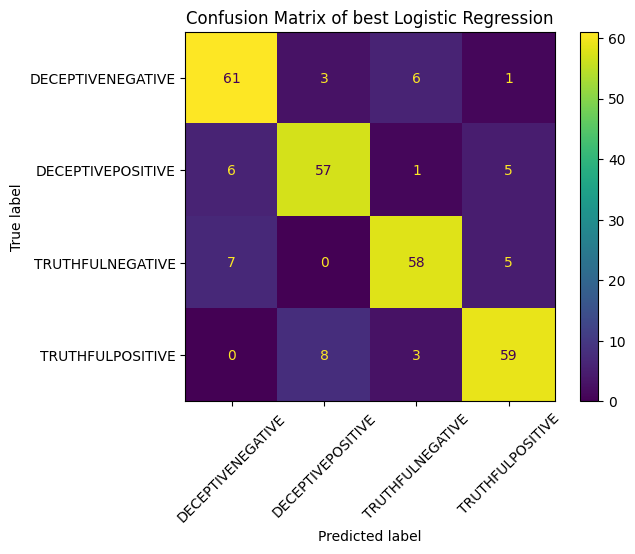

In [135]:
# plot confusion matrix of best performing model in terms of accuracy
pred_labels = lr.predict(x_test_tf)

cm = confusion_matrix(y_test, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=le.inverse_transform([0,1,2,3]))

disp.plot()
plt.xticks(rotation=45)
plt.title("Confusion Matrix of best Logistic Regression")
plt.show()

## DistilBERT

### DistilBERT as Feature Extractor

Note: we use max_length=300 here. This means some reviews will be truncated, but it doesn't seem to be an issue for the model accuracy. With higher max_length like 512 (max for BERT) the errors during training occured.

In [98]:
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# apply DistilBERT tokenizer on all soft cleaned reviews
encoded_corpus = tokenizer(
    text=data["review_soft_clean"].tolist(),
    add_special_tokens=True,
    padding="max_length",
    truncation="longest_first",
    max_length=300,
    return_attention_mask=True,
    return_tensors="tf",
)

input_ids = encoded_corpus["input_ids"]
attention_mask = encoded_corpus["attention_mask"]

le = LabelEncoder()
labels = le.fit_transform(data["sentiment"])
labels = labels.reshape(-1, 1)

In [24]:
# put complete dataset through pretrained DistilBERT to get features
# from last hidden state of model

feature_model = TFDistilBertModel.from_pretrained(checkpoint)

dataset = Dataset.from_dict({"input_ids": input_ids, "attention_mask": attention_mask})

dataset = dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    batch_size=32,
)

features = feature_model.predict(dataset, verbose=0)["last_hidden_state"][:, 0, :]


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [25]:
# DistilBERT embedding of all soft cleaned reviews
# for every review we have a 768-dimensional vector (embedding)
features.shape

(1399, 768)

In [26]:
x_train = features[train_index]
x_test = features[test_index]
y_train = data["sentiment"].values[train_index]
y_test = data["sentiment"].values[test_index]

#### Logistic Regression on DistilBERT features

In [27]:
param_grid_logreg = {
    'penalty': ['l2'],
    'C': [1, 5, 8, 10, 12],
    'max_iter': [1000],
}

logreg = LogisticRegression()

grid_search_logreg = GridSearchCV(logreg, param_grid_logreg, cv=5, n_jobs=-1)
grid_search_logreg.fit(x_train, y_train)
logreg = grid_search_logreg.best_estimator_

print("Best hyperparameters: ", grid_search_logreg.best_params_)
print("Best score: ", grid_search_logreg.best_score_)
print("Test Accuracy  : {:.2f} %".format(accuracy_score(logreg.predict(x_test), y_test)*100))

Best hyperparameters:  {'C': 1, 'max_iter': 1000, 'penalty': 'l2'}
Best score:  0.8096893017296605
Test Accuracy  : 80.36 %


#### SVM on DistilBERT features

In [28]:
param_grid_svc2 = {
        'C': [0.1, 0.5, 1, 2, 5, 10],
        'kernel': ['linear', 'rbf', 'poly'],
        'degree': [2, 3, 4],
        'gamma': ['scale', 'auto']
}

svc2 = SVC()
grid_search_svc2 = GridSearchCV(svc2, param_grid_svc2, cv=5, n_jobs=-1)
grid_search_svc2.fit(x_train, y_train)
svc2 = grid_search_svc2.best_estimator_

print("Best hyperparameters: ", grid_search_svc2.best_params_)
print("Best score: ", grid_search_svc2.best_score_)
print("Test Accuracy  : {:.2f} %".format(accuracy_score(svc2.predict(x_test), y_test)*100))

Best hyperparameters:  {'C': 0.5, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Best score:  0.8087924407431133
Test Accuracy  : 79.29 %


Worse performance than with TFIDF on untuned DistilBERT embeddings. Next try fine tuning on train data.

### DistilBERT Fine Tuning

In [100]:
dataset_train = Dataset.from_dict(
    {
        "input_ids": tf.convert_to_tensor(input_ids.numpy()[train_index]),
        "attention_mask": tf.convert_to_tensor(attention_mask.numpy()[train_index]),
        "labels": labels[train_index],
    }
)

dataset_val = Dataset.from_dict(
    {
        "input_ids": tf.convert_to_tensor(input_ids.numpy()[test_index]),
        "attention_mask": tf.convert_to_tensor(attention_mask.numpy()[test_index]),
        "labels": labels[test_index],
    }
)

dataset_train = dataset_train.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols="labels",
    shuffle=False,
    batch_size=32,
)

dataset_val = dataset_val.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols="labels",
    shuffle=False,
    batch_size=32,
)

In [101]:
distilbert = TFDistilBertForSequenceClassification.from_pretrained(checkpoint, num_labels=4)

opt = keras.optimizers.Adam(learning_rate=3e-5)
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

distilbert.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

es = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", mode="max", patience=7, restore_best_weights=True)
distilbert.fit(dataset_train, validation_data=dataset_val, epochs=20, callbacks=[es])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/20
35/35 [==============================] - 72s 1s/step - loss: 1.1196 - accuracy: 0.5710 - val_loss: 0.7837 - val_accuracy: 0.7500
Epoch 2/20
35/35 [==============================] - 37s 1s/step - loss: 0.6018 - accuracy: 0.7945 - val_loss: 0.4579 - val_accuracy: 0.8500
Epoch 3/20
35/35 [==============================] - 39s 1s/step - loss: 0.3711 - accuracy: 0.8660 - val_loss: 0.4372 - val_accuracy: 0.8179
Epoch 4/20
35/35 [==============================] - 37s 1s/step - loss: 0.2463 - accuracy: 0.9240 - val_loss: 0.4393 - val_accuracy: 0.8464
Epoch 5/20
35/35 [==============================] - 37s 1s/step - loss: 0.2165 - accuracy: 0.9285 - val_loss: 0.4139 - val_accuracy: 0.8321
Epoch 6/20
35/35 [==============================] - 40s 1s/step - loss: 0.0988 - accuracy: 0.9732 - val_loss: 0.3439 - val_accuracy: 0.8571
Epoch 7/20
35/35 [==============================] - 39s 1s/step - loss: 0.0577 - accuracy: 0.9875 - val_loss: 0.5360 - val_accuracy: 0.8321
Epoch 8/20
35/35 [==

In [102]:
print("Best validation set performance:")
distilbert.evaluate(dataset_val, return_dict=True, batch_size=32)

Validation set performance:
9/9 [==============================] - 3s 333ms/step - loss: 0.4443 - accuracy: 0.8929


{'loss': 0.44428813457489014, 'accuracy': 0.8928571343421936}

9/9 [==============================] - 3s 331ms/step


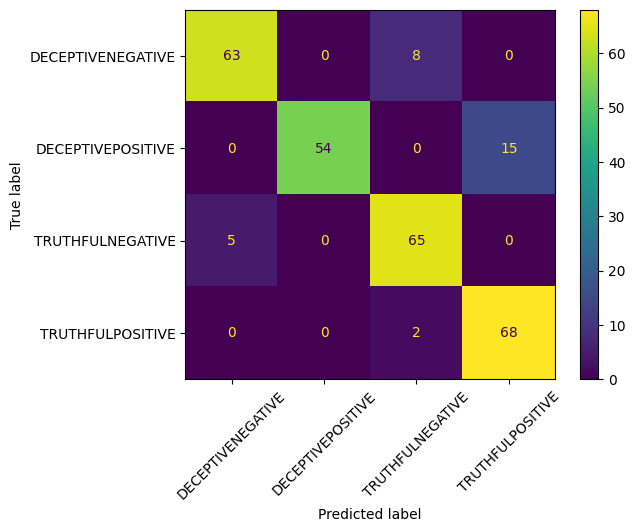

In [116]:
# plot confusion matrix of best performing model in terms of accuracy
pred = distilbert.predict(dataset_val)
pred_labels = le.inverse_transform(np.argmax(pred.logits, axis=1))

cm = confusion_matrix(y_test, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=le.inverse_transform([0,1,2,3]))

disp.plot()
plt.xticks(rotation=45)
plt.show()

# Apply Best Model to the Real Test Set

In [117]:
test = pd.read_csv("/content/drive/MyDrive/test_just_reviews.txt", sep='\t', header = 0, names = ['review'])

test["review_soft_clean"] = test["review"].apply(soft_clean_text)

encoded_test = tokenizer(
    text=test["review_soft_clean"].tolist(),
    add_special_tokens=True,
    padding="max_length",
    truncation="longest_first",
    max_length=300,
    return_attention_mask=True,
    return_tensors="tf",
)

dataset_test = Dataset.from_dict(
    {
        "input_ids": tf.convert_to_tensor(encoded_test["input_ids"].numpy()),
        "attention_mask": tf.convert_to_tensor(encoded_test["attention_mask"].numpy()),
    }
)

dataset_test = dataset_test.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    shuffle=False,
    batch_size=32,
)

pred = distilbert.predict(dataset_test)

7/7 [==============================] - 4s 291ms/step


In [118]:
# write labels to results.txt file
pred_labels = le.inverse_transform(np.argmax(pred.logits, axis=1))
with open(r'/content/drive/MyDrive/results.txt', 'w') as fp:
    for label in pred_labels:
        fp.write("%s\n" % label)